In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx

# Extract values from matrix; this is QUBO specific, but the rest of the code can take nonquadratic functions as well.

In [38]:
def linear_values(a):
    if a.shape[0] == 1:
        return np.array([0, a[0]])
    v = linear_values(a[:-1])
    return np.concatenate((v, v + a[-1]))

def quadratic_values(Q):
    if Q.shape[0] == 1:
        return np.array([0, Q[0, 0]])
    v = quadratic_values(Q[:-1, :-1])
    return np.concatenate((v, v + 2 * linear_values(Q[-1][:-1]) + Q[-1, -1]))

def qubo_values(Q):
    return np.unique(quadratic_values(Q), return_counts=True)

In [39]:
def gas_updater(p, l_gas, p_unifrom):
    cdf_inv = 1 - np.cumsum(p_unifrom)

    thetas = 2 * np.arcsin(np.sqrt(cdf_inv)) / np.pi
    P_gas_failures = (1 + np.sinc(2 * l_gas * thetas) / np.sinc(thetas)) / 2

    p_gas = p * P_gas_failures
    p_gas[1:] += np.cumsum(p[:-1] * (1 - P_gas_failures[:-1]) / cdf_inv[:-1]) * p_unifrom[1:]

    return p_gas / np.sum(p_gas) # stabilization

In [40]:
def fpgas_updater(p, delta_fpgas, l_fpgas, p_unifrom):
    cdf_inv = 1 - np.cumsum(p_unifrom)
    L_fpgas = 2 * l_fpgas + 1

    inner_chebishevs_fpgas = np.cosh(np.arccosh(1 / delta_fpgas) / L_fpgas) * np.sqrt(1 - cdf_inv)
    P_fpgas_failures = np.square(np.where(inner_chebishevs_fpgas <= 1, np.cos(np.arccos(np.minimum(inner_chebishevs_fpgas, 1)) * L_fpgas), np.cosh(np.arccosh(np.maximum(inner_chebishevs_fpgas, 1)) * L_fpgas)) * delta_fpgas)

    p_fpgas = p * P_fpgas_failures
    p_fpgas[1:] += np.cumsum(p[:-1] * (1 - P_fpgas_failures[:-1]) / cdf_inv[:-1]) * p_unifrom[1:]

    return p_fpgas / np.sum(p_fpgas) # stabilization

# graph to generate QUBO for testing

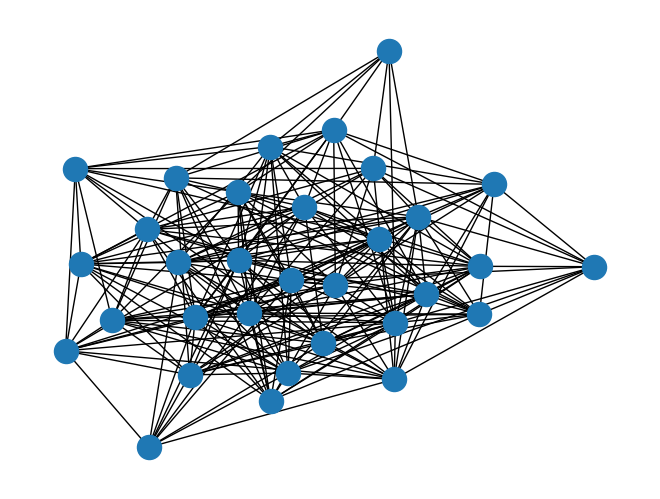

In [47]:
# random, connected graph
NumberOfVertices, EdgeProbability = 32, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)
GraphLaplacian = jnp.array(nx.laplacian_matrix(Graph).toarray())
NumberOfEdges = jnp.trace(GraphLaplacian) >> 1

# let's get rid of the vertex with the highest degree; this step is not necessary, but saves one bit
maxdegvertex = jnp.argmax(jnp.diag(GraphLaplacian))
Q = jnp.delete(jnp.delete(GraphLaplacian, maxdegvertex, 0), maxdegvertex, 1)

In [55]:
NumberOfEdges / 2

Array(114.5, dtype=float32)

In [48]:
cut_values, p_unifrom = qubo_values(Q)
MaxCut, p_unifrom = cut_values[-1],  p_unifrom / (1 << Q.shape[0])

# simulation

In [56]:
rounds = 4 # number of iterations to run

In [57]:
# runing the simulation

p_gas = np.copy(p_unifrom)
p_fpgas = np.copy(p_unifrom)



l_gas = 1
l_fpgas = 1
alpha_gas = 6/5 # paramaters for GAS from Boyer et al.
alpha_fpgas = 2 # paramaters for FPGAS / far from optimal at such a low qubit number

delta_fpgas = 0.4 # paramaters for FPGAS / probably not optimal at such a low qubit number



for idx in range(rounds):
    p_gas = gas_updater(p_gas, np.ceil(l_gas), p_unifrom)
    p_fpgas = fpgas_updater(p_fpgas, delta_fpgas, np.ceil(l_fpgas), p_unifrom)

    l_gas *= alpha_gas
    l_fpgas *= alpha_fpgas

# statistics

In [58]:
E_uniform = np.dot(p_unifrom, cut_values)

E_gas = np.dot(p_gas, cut_values)
E_fpgas = np.dot(p_fpgas, cut_values)


cut_values_squared = np.square(cut_values)

sigma_uniform = np.sqrt(np.dot(p_unifrom, cut_values_squared) - E_uniform**2)

sigma_gas = np.sqrt(np.dot(p_gas, cut_values_squared) - E_gas**2)
sigma_fpgas = np.sqrt(np.dot(p_fpgas, cut_values_squared) - E_fpgas**2)



print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_uniform / MaxCut):.2%}\t{(E_gas / MaxCut):.2%}\t{(E_fpgas / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_uniform / MaxCut):.2%}\t{(sigma_gas / MaxCut):.2%}\t{(sigma_fpgas / MaxCut):.2%}")

		maximal cut	= 146
		---------------------
		random	GAS	FPGAS

E[cut]		78.42%	84.86%	88.19%
D[cut]		5.18%	3.33%	2.60%


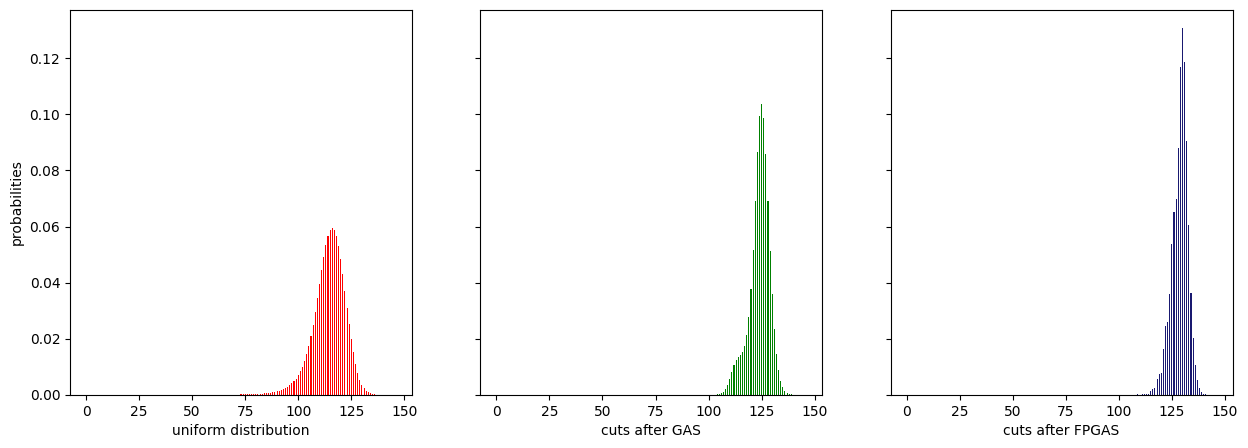

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(cut_values,
           p_unifrom,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"uniform distribution",
           ylabel=f"probabilities")

axs[1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after GAS")

axs[2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"cuts after FPGAS")

plt.show()

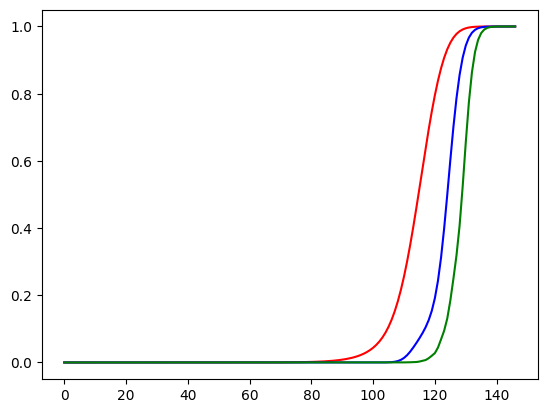

In [60]:
cdf_unifrom = np.cumsum(p_unifrom)

cdf_gas = np.cumsum(p_gas)
cdf_fpgas = np.cumsum(p_fpgas)

plt.plot(cut_values, cdf_unifrom, 'r')

plt.plot(cut_values, cdf_gas, 'b')
plt.plot(cut_values, cdf_fpgas, 'g')

plt.show()

# probabilities of finding MaxCut

In [61]:
print(f"{p_unifrom[-1]:.5%}\t{p_gas[-1]:.5%}\t{p_fpgas[-1]:.5%}")

0.00000%	0.00000%	0.00001%


In [62]:
print(f"{p_fpgas[-1] / p_unifrom[-1]:.5%}\t{p_fpgas[-1] / p_gas[-1]:.5%}")

8889.95759%	803.10150%


# with repetition

In [66]:
def repeater(distribution, r):
    CDF = np.power(np.cumsum(distribution), r)
    distribution_new = CDF - np.roll(CDF, 1)
    distribution_new[0] = CDF[0]
    return distribution_new

In [67]:
reps = NumberOfVertices**2

In [68]:
# cut statistics
p_unifrom_with_reps = repeater(p_unifrom, reps)
p_gas_with_reps = repeater(p_gas, reps)
p_fpgas_with_reps = repeater(p_fpgas, reps)

In [69]:
E_unifrom_with_reps = np.dot(p_unifrom_with_reps, cut_values)

E_gas_with_reps = np.dot(p_gas_with_reps, cut_values)
E_fpgas_with_reps = np.dot(p_fpgas_with_reps, cut_values)



sigma_unifrom_with_reps = np.sqrt(np.dot(p_unifrom_with_reps, cut_values_squared) - E_unifrom_with_reps**2)

sigma_gas_with_reps = np.sqrt(np.dot(p_gas_with_reps, cut_values_squared) - E_gas_with_reps**2)
sigma_fpgas_with_reps = np.sqrt(np.dot(p_fpgas_with_reps, cut_values_squared) - E_fpgas_with_reps**2)

In [70]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\tnumber of reps\t= {reps}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_unifrom_with_reps / MaxCut):.2%}\t{(E_gas_with_reps / MaxCut):.2%}\t{(E_fpgas_with_reps / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_unifrom_with_reps / MaxCut):.2%}\t{(sigma_gas_with_reps / MaxCut):.2%}\t{(sigma_fpgas_with_reps / MaxCut):.2%}")

		maximal cut	= 109
		---------------------
		number of reps	= 729
		---------------------
		random	GAS	FPGAS

E[cut]		90.80%	nan%	nan%
D[cut]		1.64%	nan%	nan%


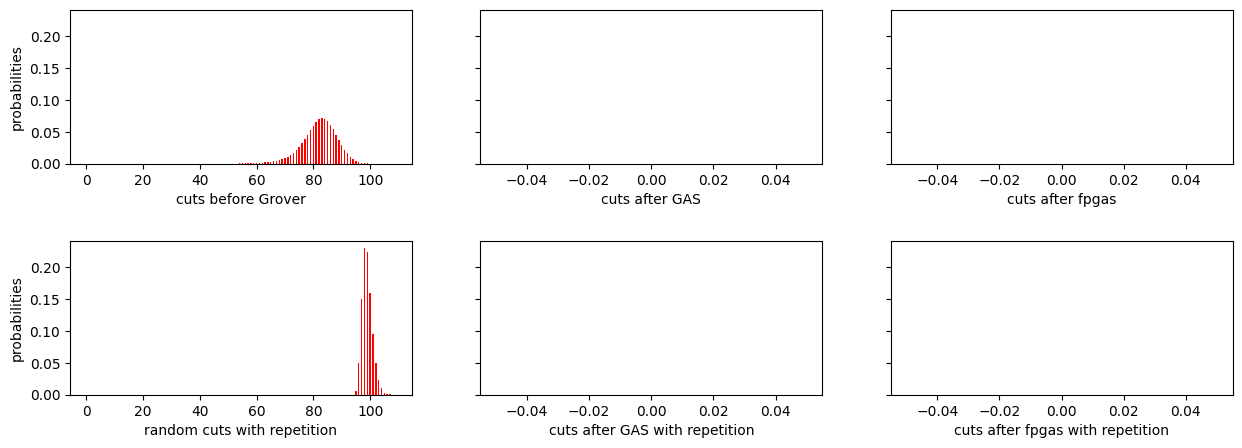

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 5))

axs[0, 0].bar(cut_values,
           p_unifrom,
           width=0.5,
           color="red")
axs[0, 0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[0, 1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[0, 1].set(xlabel=f"cuts after GAS")

axs[0, 2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[0, 2].set(xlabel=f"cuts after fpgas")

axs[1, 0].bar(cut_values,
           p_unifrom_with_reps,
           width=0.5,
           color="red")
axs[1, 0].set(xlabel=f"random cuts with repetition",
           ylabel=f"probabilities")

axs[1, 1].bar(cut_values,
           p_gas_with_reps,
           width=0.5,
           color="green")
axs[1, 1].set(xlabel=f"cuts after GAS with repetition")

axs[1, 2].bar(cut_values,
           p_fpgas_with_reps,
           width=0.5,
           color="midnightblue")
axs[1, 2].set(xlabel=f"cuts after fpgas with repetition")

plt.subplots_adjust(hspace=0.5)

plt.show()

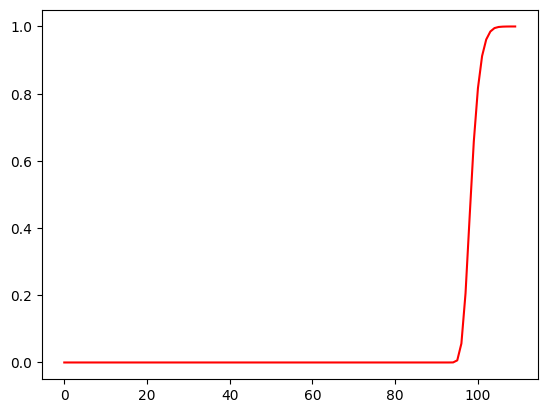

In [72]:
cdf_unifrom_with_reps = np.cumsum(p_unifrom_with_reps)

cdf_gas_with_reps = np.cumsum(p_gas_with_reps)
cdf_fpgas_with_reps = np.cumsum(p_fpgas_with_reps)



plt.plot(cut_values, cdf_unifrom_with_reps, 'r')

plt.plot(cut_values, cdf_gas_with_reps, 'b')
plt.plot(cut_values, cdf_fpgas_with_reps, 'g')

plt.show()